<a href="https://colab.research.google.com/github/ueki5/colaboratory/blob/main/playground-012.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

元データ： (506, 13) (506,)
項目名  ：  ['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO' 'B' 'LSTAT']
絞込み後： (506, 1)
[[6.575]
 [6.421]
 [7.185]
 [6.998]
 [7.147]]
正解データ
[24.  21.6 34.7 33.4 36.2]
入力次元数：1,出力次元数：1


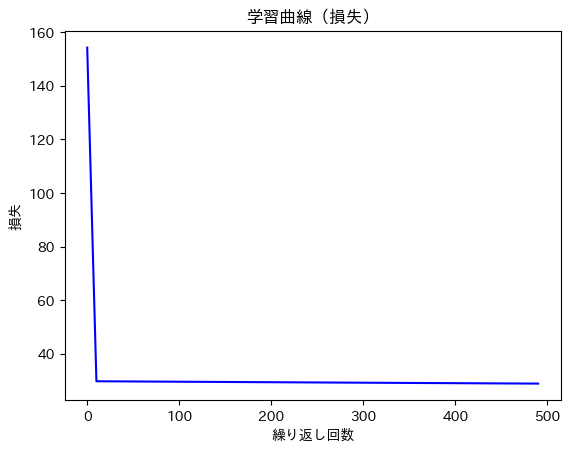

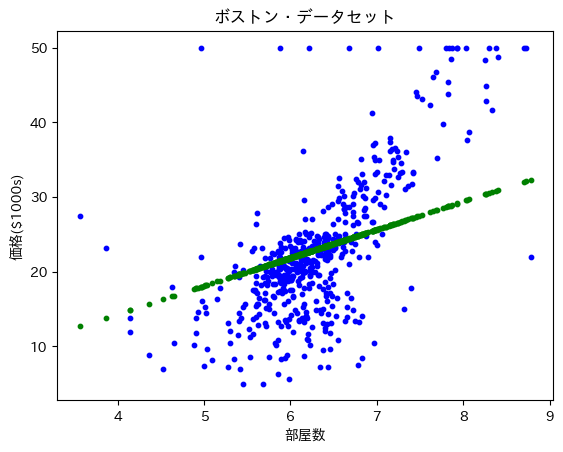

In [61]:
!pip install torchviz
!pip install torchinfo
!pip install japanize-matplotlib


元データ： (506, 13) (506,)
項目名  ：  ['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO' 'B' 'LSTAT']
絞込み後： (506, 1)
[[6.575]
 [6.421]
 [7.185]
 [6.998]
 [7.147]]
正解データ
[24.  21.6 34.7 33.4 36.2]
入力次元数：1,出力次元数：1


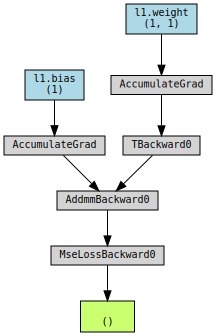

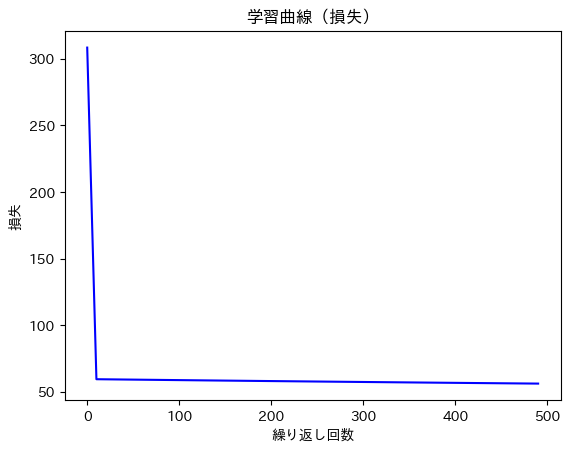

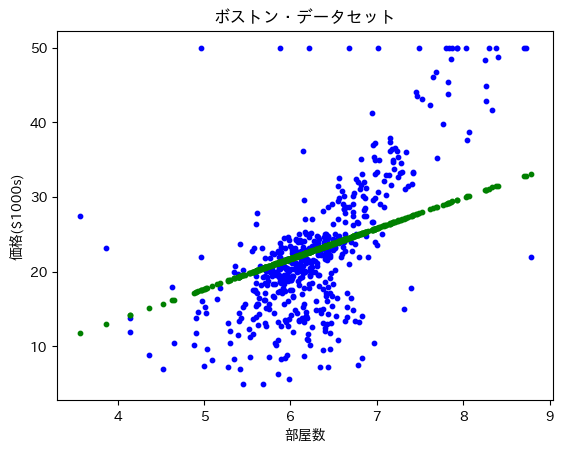

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import torch
from torchinfo import summary
from torchviz import make_dot
pd.set_option('display.width', 160)
np.set_printoptions(linewidth=160)

# 学習用データ準備
# --- http://lib.stat.cmu.edu/datasets/boston ---
#  The Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic
#  prices and the demand for clean air', J. Environ. Economics & Management,
#  vol.5, 81-102, 1978.   Used in Belsley, Kuh & Welsch, 'Regression diagnostics
#  ...', Wiley, 1980.   N.B. Various transformations are used in the table on
#  pages 244-261 of the latter.

#  Variables in order:
#  CRIM     per capita crime rate by town
#  ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
#  INDUS    proportion of non-retail business acres per town
#  CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
#  NOX      nitric oxides concentration (parts per 10 million)
#  RM       average number of rooms per dwelling
#  AGE      proportion of owner-occupied units built prior to 1940
#  DIS      weighted distances to five Boston employment centres
#  RAD      index of accessibility to radial highways
#  TAX      full-value property-tax rate per $10,000
#  PTRATIO  pupil-teacher ratio by town
#  B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
#  LSTAT    % lower status of the population
#  MEDV     Median value of owner-occupied homes in $1000's

#  0.00632  18.00   2.310  0  0.5380  6.5750  65.20  4.0900   1  296.0  15.30
#   396.90   4.98  24.00
#  0.02731   0.00   7.070  0  0.4690  6.4210  78.90  4.9671   2  242.0  17.80
#   396.90   9.14  21.60
# ↑折り返しがあるため、２種類のデータになってしまっている

data_url = "http://lib.stat.cmu.edu/datasets/boston"
# データ説明の22行をスキップし、空白で分割
raw_df = pd.read_csv(data_url, sep=r'\s+', skiprows=22, header=None)
# 奇数行（CRIM ～ PTRATIO）
bef_wrapping = raw_df.values[ ::2, :]
# 偶数行（B ～ LSTAT）
aft_wrapping = raw_df.values[1::2, :2]
# 水平結合して１つのデータにする（CRIM ～ LSTAT）
x_org = np.hstack([bef_wrapping, aft_wrapping])
# MEDV
yt = raw_df.values[1::2, 2]
feature_names = np.array([
    'CRIM',
    'ZN',
    'INDUS',
    'CHAS',
    'NOX',
    'RM',
    'AGE',
    'DIS',
    'RAD',
    'TAX',
    'PTRATIO',
    'B',
    'LSTAT',
])

# 結果確認
print('元データ：', x_org.shape, yt.shape)
print('項目名  ： ', feature_names)

# データの絞込み（項目RMのみ）
x = x_org[:, feature_names == 'RM']
print('絞込み後：', x.shape)
print(x[:5, :])

# 正解データyの表示
print('正解データ')
print(yt[:5])

# 変数定義

# 入力次元数
n_input = x.shape[1]
# 出力次元数
n_output = 1
print(f"入力次元数：{n_input},出力次元数：{n_output}")

# カスタムクラス
class Net(torch.nn.Module):
  # 初期化
  def __init__(self, n_input, n_output):
    super().__init__()
    # 線形関数を生成
    self.l1 = torch.nn.Linear(n_input, n_output)
    # 重み、バイアスの初期値を設定
    torch.nn.init.constant_(self.l1.weight, 1.0)
    torch.nn.init.constant_(self.l1.bias, 1.0)

  # 予測関数
  def forward(self, inputs):
    outputs = self.l1(inputs) # 線形回帰
    return outputs

# 入力データ
inputs = torch.tensor(x).float()

# 教師データ
labels = torch.tensor(yt).float().view(-1, 1)

# カスタムクラスを生成
net = Net(n_input, n_output)

# 繰り返し回数
num_epochs = 500

# 学習率
lr = 0.01

# 最適化関数（勾配降下法）
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

# 記録用配列初期化
history = np.zeros((0, 2))

for epoch in range(num_epochs):

  # 予測計算
  outputs = net(inputs)
  # summary(net, (1,)) # なぜ何も表示されない？
  # for param in net.named_parameters():
  #   print(f'変数名：{param[0]}')
  #   print(f'変数値：{param[1].data}')

  # 損失関数
  criterion = torch.nn.MSELoss()

  # 誤差計算
  loss = criterion(outputs, labels) / 2.0
  if epoch == 0:
    g = make_dot(loss, params=dict(net.named_parameters()))
    display(g)

  # 勾配計算
  loss.backward()

  # 最適化
  optimizer.step()
  optimizer.zero_grad()

  if (epoch % 10 == 0):
    item = np.array([epoch, loss.item()])
    history = np.vstack((history, item))

# 学習曲線の表示（損失）
plt.plot(history[:, 0], history[:, 1], 'b')
plt.xlabel('繰り返し回数')
plt.ylabel('損失')
plt.title('学習曲線（損失）')
plt.show()

# 予測データを表示
plt.scatter(x, yt, s=10, c='b')
plt.xlabel('部屋数')
plt.ylabel('価格($1000s)')
plt.scatter(inputs.data, outputs.data, s=10, c='g')
plt.title('ボストン・データセット')
plt.show()